In [32]:
## imports 
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt


In [39]:
# Let's define a generic bandit class
   
n_trials = 500
t_max = 250

In [42]:
## And three actions

n_actions = 3

def action_0():
    return np.random.choice([1,-1], p=[0.5, 0.5])

def action_1():
    return np.random.choice([1,-1], p=[0.6, 0.4])

def action_2():
    return np.random.choice([1,-1], p=[0.2, 0.8])

rewards = [action_0, action_1, action_2]


# bandit class
class Bandit(object):
    def __init__(self,n_actions):
        self.counts = np.zeros(n_actions)
        self.action_rewards = [[] for i in range(n_actions)]
        self.rewards = []
        self.n_actions = n_actions
        
    def select_action(self):
        """Selection which arm/action to pull"""
        pass
    
    def update(self,action,reward):
        """Update the actions"""
        self.counts[action] = self.counts[action] + 1
        self.action_rewards[action].append(reward)
        self.rewards.append(reward)
        
    def get_Q_values(self):
        Q_values = []
        for q_v in self.action_rewards:
            Q_values.append(np.array(q_v).mean())
        return np.array(Q_values)
    
    def get_V_value(self):
        return np.array(self.v_value.mean())



## E-greedy


class Egreedy(Bandit):
    def __init__(self, epsilon,  *args,  **kwargs):
        super(Egreedy, self).__init__(*args, **kwargs)
        self.epsilon = epsilon
        
    def select_action(self):
        
       
        
        #never_visited = np.nonzero(self.counts == 0)
#         print indices_zero, "dfdf"
        never_visited = np.where(self.counts == 0)[0]
        #print never_visited
        if(len(never_visited)!=0):
            return np.random.choice(never_visited)
        
        
        #print never_visited, "never"
        Q_values = self.get_Q_values()
        if np.random.random() > self.epsilon:
            return np.argmax(Q_values)
        else:
            return np.random.randint(self.n_actions)
        

class UCB(Bandit):
    def __init__(self,  *args,  **kwargs):
        super(UCB, self).__init__(*args, **kwargs)
        
        
    def select_action(self):
        
       
        never_visited = np.where(self.counts == 0)[0]
        #print never_visited
        if(len(never_visited)!=0):
            return np.random.choice(never_visited)
        
        #print self.counts
        #print never_visited, "never"
        Q_values = self.get_Q_values()
        #UCB = Q_values + np.sqrt(2 * np.log(len(self.v_values) + 1) / numPlays)
        #print self.counts
        for i in range(0,len(Q_values)):
            #print np.sqrt((2 * np.log(len(self.v_values) + 1)) / len(self.q_values[i]))
            Q_values[i]+= 0.5 *  np.sqrt(( np.log(len(self.rewards))) / len(self.action_rewards[i]))
        return np.argmax(Q_values)

    
class BootstrapThompson(Bandit):
    def __init__(self, *args,  **kwargs):
        super(BootstrapThompson, self).__init__(*args, **kwargs)
        #self.heads = [[[] for range(self.n_actions)] for range(n_heads)]
        #self.n_heads = n_heads
        
        
    def select_action(self):
        
       
        never_visited = np.where(self.counts < 5)[0]
        #print never_visited
        if(len(never_visited)!=0):
            return np.random.choice(never_visited)
        
        Q_values = []
        for i,q_v in enumerate(self.action_rewards):
            b_sample = np.random.choice(q_v, len(q_v), replace=True)
            Q_values.append(b_sample.mean())
            #print i, q_v, "qv"
        #print Q_values
        #print ("===========")
        return np.array(Q_values).argmax()
    




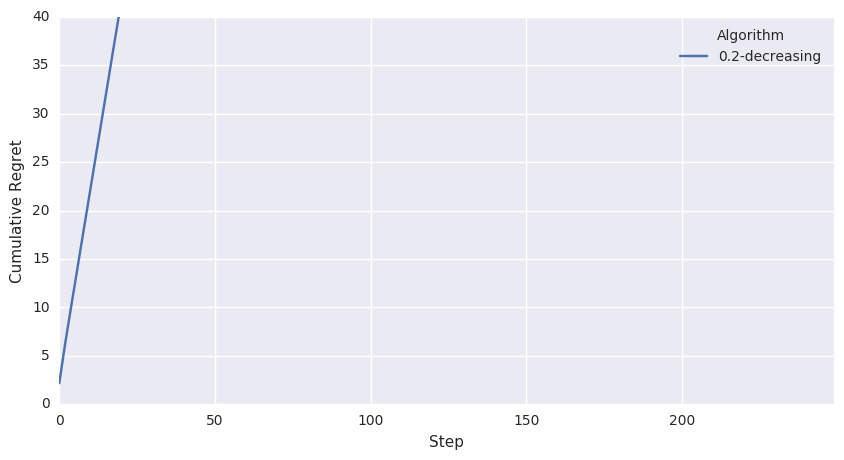

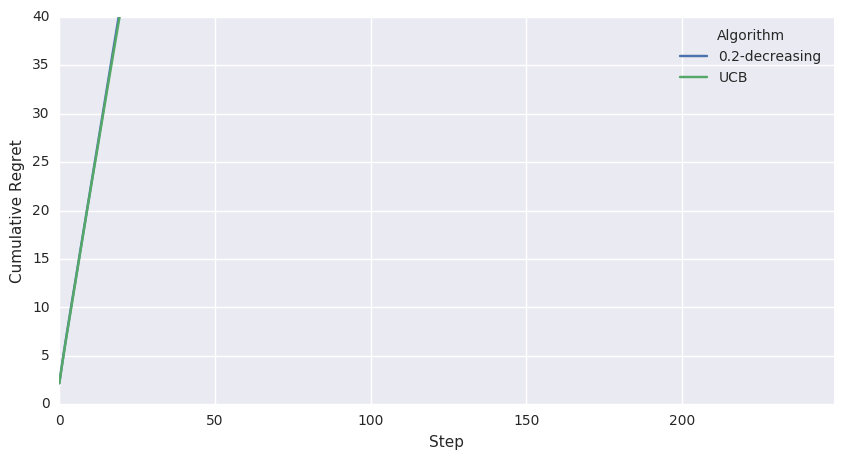

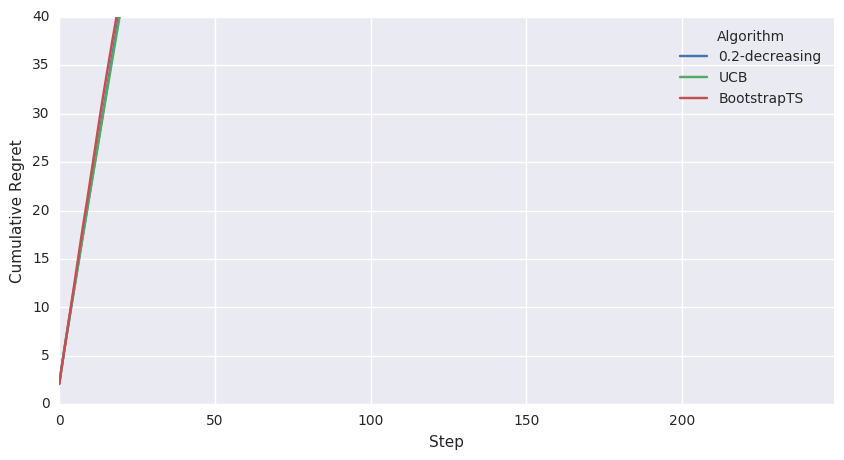

In [43]:
data = []

bandits = [
           ("0.2-decreasing",  lambda: Egreedy(epsilon = 0.2, n_actions = n_actions)),
           ("UCB", lambda: UCB( n_actions = n_actions)),
           ("BootstrapTS",  lambda: BootstrapThompson( n_actions = n_actions)),
          
          ]

for b in bandits:

    columns =["Step", "Cumulative Regret", "trial", "Algorithm"]
    df = pd.DataFrame()

   
    for trial in (range(n_trials)):
        gaps = []
        bandit = b[1]()
       
        for i in range(t_max):
            # select action
            action = bandit.select_action()
            # get the reward
            reward = rewards[action]()
            # update the 
            bandit.update(action, reward)
            # Super hack for the lazy
            if(b[0].endswith("decreasing")):
                #print "decreasing"
                bandit.epsilon*=0.99
               
            gaps.append(2 - reward)
            regret = np.array(gaps).sum()
            data.append([i,regret,trial, b[0]])
            #print df.head()
        #print trial
    df = df.append(data)
    df.columns = columns
    df.head()
    plt.figure(figsize=(10, 5))

    axes = sns.tsplot(time="Step", value="Cumulative Regret",
                     unit="trial", condition="Algorithm",data=df)


    axes.set_ylim([0,40])

    plt.savefig(b[0] + ".pdf",bbox_inches='tight')